In [315]:
import os

import matplotlib.pyplot as plt
import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from dotenv import load_dotenv
from numpy import pi
from qiskit import (IBMQ, Aer, ClassicalRegister, QuantumCircuit,
                    QuantumRegister, transpile)
from qiskit.ignis.verification.tomography import (StateTomographyFitter,
                                                  state_tomography_circuits)
from qiskit.providers.aer import AerSimulator, noise
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.quantum_info import partial_trace
from qutip import Bloch, Bloch3d, Qobj
from tqdm import tqdm
from tqdm.contrib import tenumerate

from sync_calcs import dm2bloch, spin_husimi_qfunc, spin_S_measure
from sync_gates import add_tomography
from sync_plots import *

load_dotenv()

import logging

logging.getLogger('qiskit.providers.ibmq').setLevel(logging.ERROR)


In [316]:
backend = Aer.get_backend('statevector_simulator')

# Parameters

In [317]:
# Simulation Steps
SIM_STEPS = 5000

# Qubits of physical device to use
# Ordered from zero
main = 0
ancilla = 1

gain_amp = 1
loss_amp = 0.1
m = min(loss_amp, gain_amp)

detuning = 3 * m
signal_strength = 2 * m
dt = 0.5

In [318]:
# Plotting constants
n = 20  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

# Circuit

In [319]:
def generate_circuit(time_steps, detuning, signal_strength, steps, main, ancilla):
    qreg_q = QuantumRegister(max(main, ancilla) + 1, "q")
    creg_c = ClassicalRegister(2, "c")

    qc = QuantumCircuit(qreg_q, creg_c)

    for i in range(steps):
        if hasattr(time_steps, "__iter__"):
            dt = time_steps[i]
        else:
            dt = time_steps
        theta_d = 2 * np.arcsin(np.sqrt(loss_amp * dt))
        theta_g = 2 * np.arcsin(np.sqrt(gain_amp * dt))

        theta = signal_strength * dt
        phi = pi - detuning * dt / 2
        lam = pi - detuning * dt / 2

        qc.u(theta, phi, lam, qreg_q[main])

        # Loss CU
        # qc.cu(theta_d, 0, 0, 0, qreg_q[main], qreg_q[ancilla])
        # qc.cx(qreg_q[ancilla], qreg_q[main])
        # qc.measure(qreg_q[ancilla], creg_c[0])
        # qc.reset(qreg_q[ancilla])

        # Loss 2xCX
        qc.u(pi / 2, -pi, 0, qreg_q[main])
        qc.u(-theta_d / 2, -pi / 2, pi, qreg_q[ancilla])
        qc.cx(qreg_q[ancilla], qreg_q[main])
        qc.u(pi / 2, -pi / 2, 0, qreg_q[main])
        qc.u(-theta_d / 2, pi, pi / 2, qreg_q[ancilla])
        qc.cx(qreg_q[ancilla], qreg_q[main])
        qc.u(0, 0, -pi / 2, qreg_q[main])
        qc.u(0, 0, -pi / 2, qreg_q[ancilla])
        qc.measure(qreg_q[ancilla], creg_c[0])
        qc.reset(qreg_q[ancilla])

        # # Gain
        qc.u(-pi, 0, 0, qreg_q[main])
        qc.cx(qreg_q[main], qreg_q[ancilla])
        qc.cu(theta_g, 0, 0, 0, qreg_q[main], qreg_q[ancilla])
        qc.cx(qreg_q[main], qreg_q[ancilla])
        qc.u(pi, 0, 0, qreg_q[main])
        qc.measure(qreg_q[ancilla], creg_c[0])
        qc.reset(qreg_q[ancilla])

    return qc


In [320]:
gain_amp=0.1
loss_amp=1
DR = 1
detunings = np.linspace(-DR, DR, n)

In [321]:
S = np.zeros([2*n, n])

for i, D in enumerate(detunings):
    circuit = generate_circuit(dt, D, loss_amp, SIM_STEPS, main, ancilla)
    circuit = transpile(circuit, backend)
    job = backend.run(circuit)
    prod_state = job.result().get_statevector(0)
    state = partial_trace(prod_state, [1])
    s = state.data
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

In [322]:
# circuit = generate_circuit(dt, 0.1, loss_amp, 1000, main, ancilla)
# circuit = transpile(circuit, backend)
# job = backend.run(circuit)
# prod_state = job.result().get_statevector(0)
# state = partial_trace(prod_state, [1])
# s = state.data
# # s[0,0], s[1,1] = s[1,1], s[0,0]
# # s[0,1], s[1,0] = s[1,0], s[0,1]
# state = Qobj(s)
# state

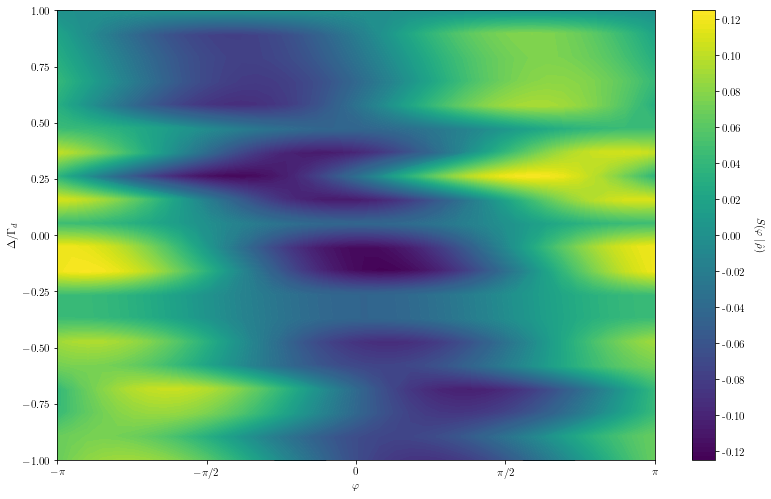

In [323]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH * 2))

DETUNING, PHI = np.meshgrid(detunings / loss_amp, phi)

cquad = ax.contourf(PHI, DETUNING, S, 100)
for c in cquad.collections:
    c.set_edgecolor("face")
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\Delta/\Gamma_d$')

cbar = fig.colorbar(cquad)
cbar.set_label(r"$S(\varphi\,|\,\hat\rho)$", rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_locator(MultipleLocator(base=0.02))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
angle_xaxis(ax)



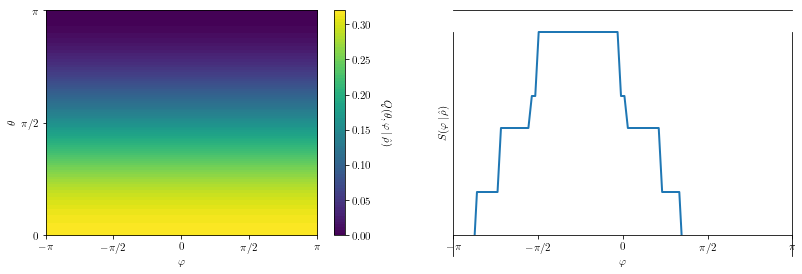

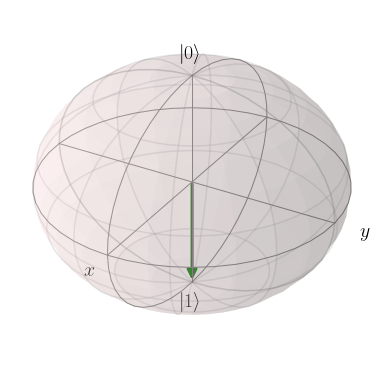

In [324]:
calc_and_plot_Q_and_S(Qobj(state.data))

b = Bloch()

b.add_states(state)

b.show()